In [1]:
import pandas as pd
import numpy as np
from scipy.stats import iqr
import matplotlib.pyplot as plt
import zipfile
import urllib.request

url = 'http://ergast.com/downloads/f1db_csv.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zf = zipfile.ZipFile(filehandle, 'r')

results_df = pd.read_csv(zf.open('results.csv'))
drivers_df = pd.read_csv(zf.open('drivers.csv'))
lap_times_df = pd.read_csv(zf.open('lap_times.csv'))
races_df = pd.read_csv(zf.open('races.csv'))
pit_stops_df = pd.read_csv(zf.open('pit_stops.csv'))
constructors_df = pd.read_csv(zf.open('constructors.csv'))
circuits_df = pd.read_csv(zf.open('circuits.csv'))
pit_stops_df = pd.read_csv(zf.open('pit_stops.csv'))

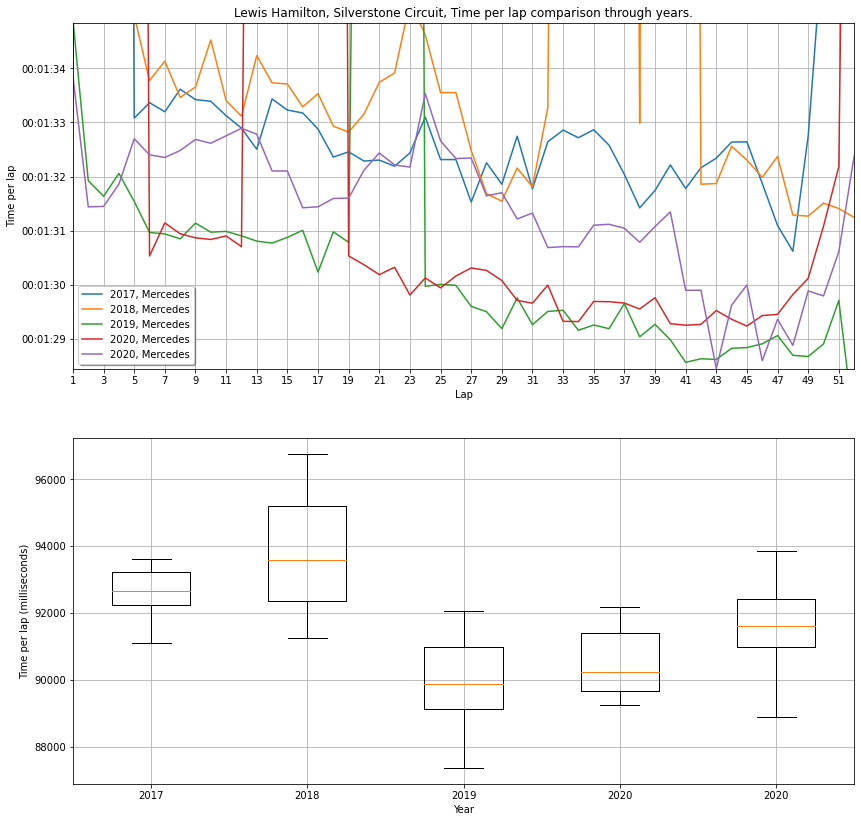

In [2]:
circuitRef = 'silverstone'
circuitId = circuits_df[circuits_df.circuitRef == circuitRef]['circuitId'].iloc[0]

driverRef = 'hamilton'
driverId = drivers_df[drivers_df.driverRef == driverRef]['driverId'].iloc[0]
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)

last_5_raceId = races_df[races_df.circuitId == circuitId].sort_values("year").raceId.iloc[-5:]
for raceId in last_5_raceId:
    race_df = lap_times_df[(lap_times_df.raceId == raceId) & (lap_times_df.driverId == driverId)].copy()
    
    pit_stop_df = pit_stops_df[(pit_stops_df.raceId == raceId) & (pit_stops_df.driverId == driverId)]

    for lap in pit_stop_df.lap:
        race_df.loc[race_df.lap.isin([lap, lap + 1]),'milliseconds'] = np.nan
        mean_value = race_df.loc[race_df.lap.isin([lap - 1, lap + 2])].milliseconds.mean()
        race_df.loc[race_df.lap.isin([lap, lap + 1]),'milliseconds'] = mean_value
    
    race_year = str(races_df[races_df.raceId == raceId].year.iloc[0])
    constructorId = results_df[(results_df.raceId == raceId) & (results_df.driverId == driverId)].constructorId.iloc[0]
    constructor_name = constructors_df[constructors_df.constructorId == constructorId].name.iloc[0]
    label = race_year + ', ' + constructor_name
    plt.plot(race_df.lap,
             pd.to_datetime(race_df.milliseconds, unit='ms'),
             label = label)

driver_forename = drivers_df[drivers_df.driverRef == driverRef].forename.iloc[0]
driver_surname = drivers_df[drivers_df.driverRef == driverRef].surname.iloc[0]
circuit_name = circuits_df[circuits_df.circuitRef == circuitRef].name.iloc[0]

high_lim = race_df.milliseconds.quantile(0.75) + iqr(race_df.milliseconds) * 1.5
min_ms_value = race_df.milliseconds.min()

race_df = lap_times_df[(lap_times_df.raceId.isin(last_5_raceId)) & (lap_times_df.driverId == driverId)].copy()

plt.xticks(np.arange(race_df["lap"].values.min(), race_df["lap"].values.max()+1, 2.0))
plt.xlim(race_df["lap"].values.min(), race_df["lap"].values.max())
plt.ylim(pd.to_datetime([min_ms_value, high_lim] , unit='ms'))
plt.title(driver_forename + ' ' + driver_surname + ', ' + circuit_name + ', Time per lap comparison through years.')
plt.xlabel('Lap')
plt.ylabel('Time per lap')
plt.legend(fancybox=True, shadow=True)
plt.grid()

plt.subplot(2, 1, 2)

for count ,raceId in enumerate(last_5_raceId):
    race_df = lap_times_df[(lap_times_df.raceId == raceId) & (lap_times_df.driverId == driverId)].copy()
    race_year = str(races_df[races_df.raceId == raceId].year.iloc[0])
    plt.boxplot(race_df.milliseconds,
                positions=[count + 1],
                widths=0.5,
                showfliers=False,
                labels=[race_year])

plt.xlabel('Year')
plt.ylabel('Time per lap (milliseconds)')
plt.grid()
plt.show()